In [1]:
%matplotlib inline
from IPython.display import display, Markdown
from datetime import time, datetime, date, timedelta
import snakemd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates

import fitfile
from garmindb import GarminConnectConfigManager
from garmindb.garmindb import GarminDb, Attributes, ActivitiesDb, Activities, StepsActivities, ActivityLaps, ActivityRecords
from idbutils.list_and_dict import list_not_none

from jupyter_funcs import format_number

gc_config = GarminConnectConfigManager()
db_params_dict = gc_config.get_db_params()

garmin_db = GarminDb(db_params_dict)
garmin_act_db = ActivitiesDb(db_params_dict)
measurement_system = Attributes.measurements_type(garmin_db)
unit_strings = fitfile.units.unit_strings[measurement_system]
distance_units = {"kilometers": "km"}[unit_strings[fitfile.units.UnitTypes.distance_long]]

def __format_activity(activity):
    if activity:
        return [activity.activity_id, activity.name, activity.start_time.strftime("%y%m%d"), activity.sport, format_number(activity.distance, 1), activity.elapsed_time, activity.moving_time, format_number(activity.avg_speed, 1), format_number(activity.calories), activity.training_load, activity.training_effect, activity.anaerobic_training_effect]
    return ['', '', '', '', '', '', '', '', '', '', '', '']


activities = Activities.get_latest(garmin_act_db, Activities.row_count(garmin_act_db))

In [2]:
def debug(name=None):
    doc = snakemd.new_doc()
    if (name is None):
        rows = [__format_activity(activity) for activity in activities]
    else:
        rows = [__format_activity(activity) for activity in activities if ((activity.name is not None) and (name in activity.name.lower()))]
    doc.add_heading("All Recorded Activities", 3)
    doc.add_table(['Id', 'Name', 'Date', 'Sport', f'Dist ({distance_units})', 'Elapsed Time', f'Moving Time', f'Speed ({unit_strings[fitfile.units.UnitTypes.speed]})', 'Calories', 'Exercise Load', 'Aerobic effect', 'Anaerobic effect'], rows)
    display(Markdown(str(doc)))

In [3]:
import numpy as np
import warnings

def __plot_activity(name:str, ydata:str, cdata:str, ylimdata = None, yticksdata:tuple[float, float] = None):
    start_date_array = []
    moving_time_array = []
    distance_array = []
    calorie_array = []
    time100m_array = []
    time1000m_array = []
    speed_array = []
    training_load_array = []
    training_effect_array = []
    anaerobic_training_effect_array = []
    for activity in activities:
        if ((activity.name is not None) and (name in activity.name.lower())):
            s = activity.distance if activity.distance is not None else 0
            t = (datetime.combine(date.min, activity.moving_time) - datetime.min).total_seconds() if activity.moving_time else 0
            if (s > 0):
                time100m_array += [t/s/10]
                time1000m_array += [t/s]
            else:
                time100m_array += [np.nan]
                time1000m_array += [np.nan]
            start_date_array += [activity.start_time]
            moving_time_array += [t/60 if t else np.nan]  # Convert seconds to minutes
            calorie_array += [activity.calories if activity.calories is not None else np.nan]
            distance_array += [s if s else np.nan]
            speed_array += [activity.avg_speed if activity.avg_speed is not None else np.nan]
            training_load_array += [activity.training_load if activity.training_load is not None else np.nan]
            training_effect_array += [activity.training_effect if activity.training_effect is not None else np.nan]
            anaerobic_training_effect_array += [activity.anaerobic_training_effect if activity.anaerobic_training_effect is not None else np.nan]

    yarray = []
    carray = []
    match ydata:
        case "Moving Time": yarray = moving_time_array
        case "Calorie": yarray = calorie_array
        case "Distance": yarray = distance_array
        case "100m Time": yarray = time100m_array
        case "1k Time": yarray = time1000m_array
        case "Speed": yarray = speed_array
        case "Exercise Load": yarray = training_load_array
        case "Training Effect": yarray = training_effect_array
        case "Anaerobic Training Effect": yarray = anaerobic_training_effect_array
    match cdata:
        case "Moving Time": carray = moving_time_array
        case "Calorie": carray = calorie_array
        case "Distance": carray = distance_array
        case "100m Time": carray = time100m_array
        case "1k Time": carray = time1000m_array
        case "Speed": carray = speed_array
        case "Exercise Load": carray = training_load_array
        case "Training Effect": carray = training_effect_array
        case "Anaerobic Training Effect": carray = anaerobic_training_effect_array

    # Check if there are any matching activities
    if len(start_date_array) == 0:
        print(f"No activities found matching '{name}'")
        return
    
    # Convert to numpy arrays with float type
    x_num = np.array(dates.date2num(start_date_array), dtype=float)
    yarray = np.array(yarray, dtype=float)
    carray = np.array(carray, dtype=float)
    
    # Find valid (non-NaN) indices
    valid_idx = np.isfinite(x_num) & np.isfinite(yarray)
    
    if not np.any(valid_idx):
        print(f"No valid data points for '{name}' with {ydata}")
        return
    
    x_clean = x_num[valid_idx]
    y_clean = yarray[valid_idx]
    c_clean = carray[valid_idx] if np.any(np.isfinite(carray[valid_idx])) else np.zeros_like(y_clean)
    
    fig = plt.figure(figsize=(20,5), dpi=100, facecolor='w', edgecolor='k')
    plt.scatter(dates.num2date(x_clean), y_clean, c=c_clean, cmap="rainbow")

    # Suppress polyfit warnings for small datasets
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', message='Polyfit may be poorly conditioned')
        
        if len(x_clean) >= 4:
            # Filter outliers before trend calculation
            initial_trend = np.polyfit(x_clean, y_clean, 3)
            initial_fit = np.poly1d(initial_trend)
            residuals = y_clean - initial_fit(x_clean)

            # Keep 95% of points closest to the trend
            residual_threshold = np.percentile(np.abs(residuals), 95)
            mask = np.abs(residuals) <= residual_threshold

            # Fit final trend on filtered data
            trend = np.polyfit(x_clean[mask], y_clean[mask], 3)
            fit = np.poly1d(trend)
            x_fit = np.linspace(x_clean.min(), x_clean.max())
            plt.plot(dates.num2date(x_fit), fit(x_fit), "r--")

    ax = plt.gca()
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    years = plt.matplotlib.dates.YearLocator()
    months = plt.matplotlib.dates.MonthLocator()
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_minor_locator(months)

    plt.title(f"{ydata} across {len(x_clean)} {name} sessions")
    plt.colorbar(label=cdata)
    plt.ylabel(ydata)
    if ylimdata is not None:
        plt.ylim(ylimdata)
    if yticksdata is not None:
        plt.yticks(yticksdata)
    plt.show()


No activities found matching 'swim'
No activities found matching 'swim'


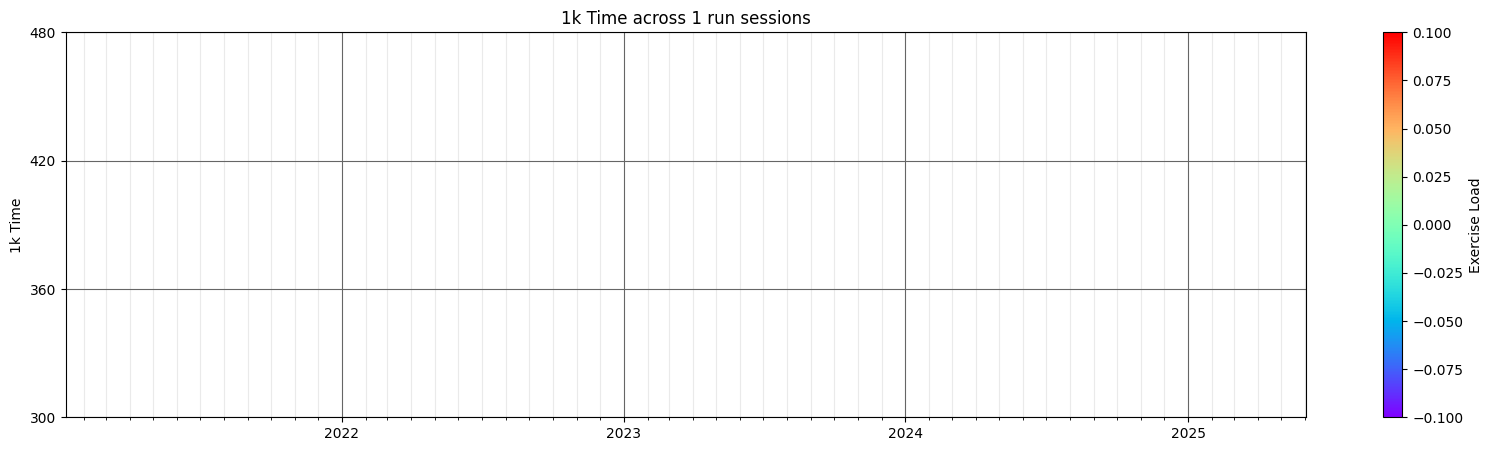

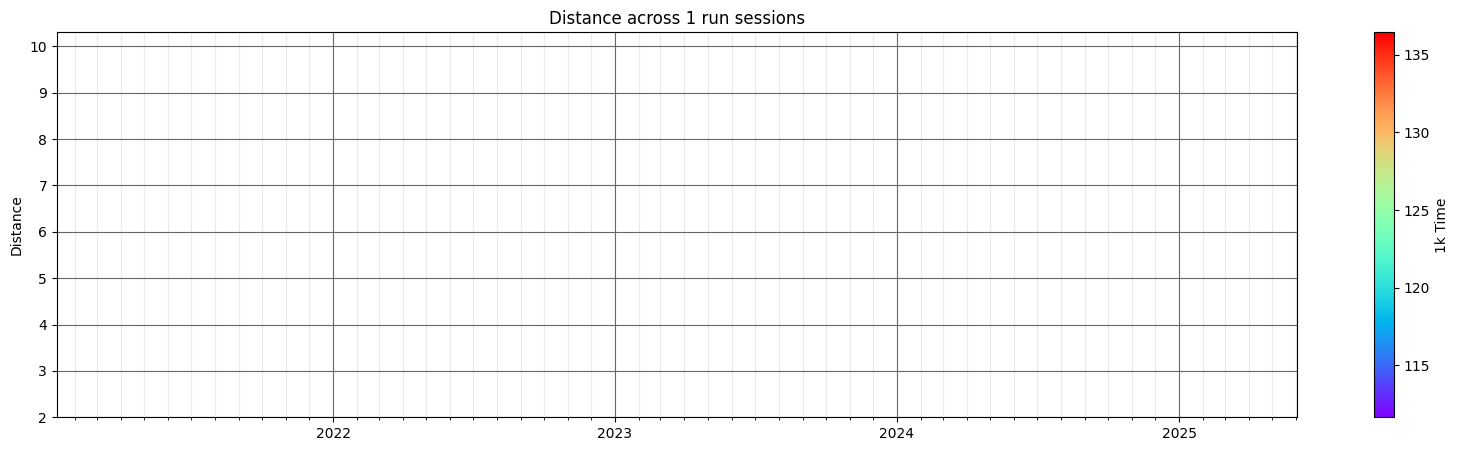

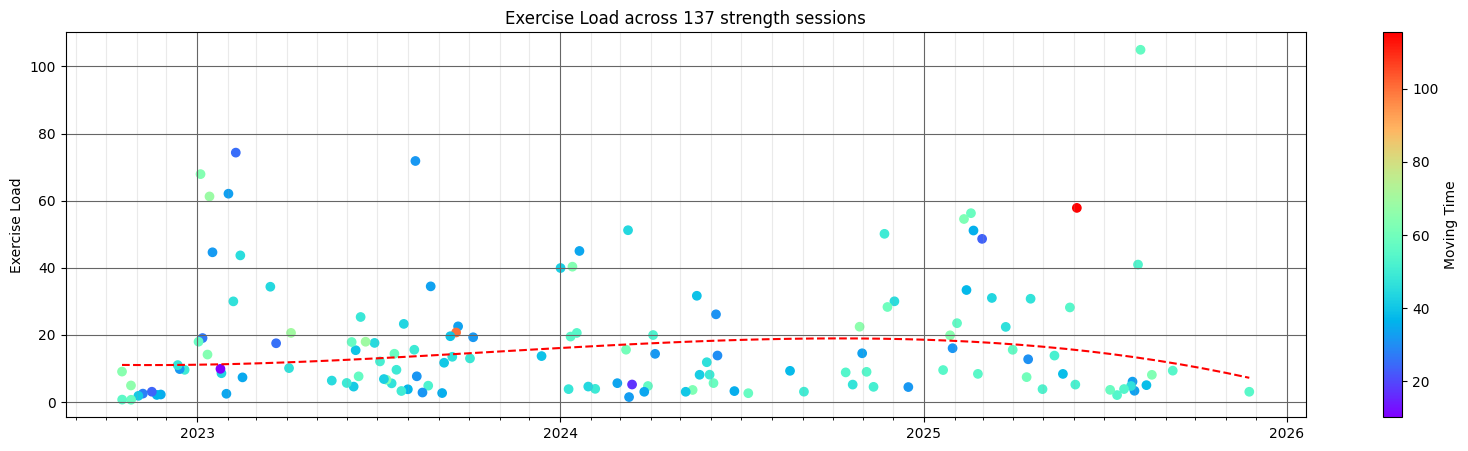

In [4]:
__plot_activity("swim", "100m Time", "Distance")
__plot_activity("swim", "Distance", "100m Time", ylimdata=[0, 1])
__plot_activity("run", "1k Time", "Exercise Load", yticksdata=[300, 360, 420, 480], ylimdata=[300, 480])
__plot_activity("run", "Distance", "1k Time", ylimdata=[2, 10.3])
__plot_activity("strength", "Exercise Load", "Moving Time")
